In [4]:

import polars as pl
import pandas as pd
import numpy as np
import pyarrow
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances, manhattan_distances
import warnings
from statsmodels.stats.multitest import multipletests
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr, spearmanr
from collections import Counter
from scipy.stats import norm
import os
# add preprocess module to path
import sys
sys.path.append('../../src/utils')

from preprocess import * 




### Load ATAC and RNA data (log transform RNA)

In [6]:
# load atac data with polars and convert to pandas (faster)
atac_data_pl = pl.read_csv('../../data/embryo/raw/atac_peak_matrix_complete_sparse.csv')
atac_data_df = atac_data_pl.to_pandas(use_pyarrow_extension_array=False)


In [7]:
rna_data_pl = pl.read_csv('../../data/embryo/raw/scRNA_countMatrix.csv', ignore_errors=True)
rna_data_df = rna_data_pl.to_pandas(use_pyarrow_extension_array=False)
rna_data_df.set_index(rna_data_df.columns[0], inplace=True)
rna_data_df[rna_data_df.isna().any(axis=1)].dropna(axis=0, how='any', inplace=True)
rna_data_log = rna_data_df.copy()
rna_data_log.iloc[:, 0:] = np.log2(rna_data_log.iloc[:, 0:].astype(float) + 1)
rna_data_log


/tmp/ipykernel_1853313/1598646211.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rna_data_df[rna_data_df.isna().any(axis=1)].dropna(axis=0, how='any', inplace=True)


,10h-1_CELL1140_N1_10h-1,10h-1_CELL1447_N1_10h-1,10h-1_CELL1347_N1_10h-1,10h-1_CELL1204_N1_10h-1,10h-1_CELL97_N2_10h-1,10h-1_CELL539_N1_10h-1,10h-1_CELL310_N1_10h-1,10h-1_CELL311_N1_10h-1,10h-1_CELL665_N1_10h-1,10h-1_CELL350_N1_10h-1,...,6h_3 CELL3882_N1 _,6h_3 CELL5301_N1 _,6h_3 CELL5240_N1 _,6h_3 CELL5143_N1 _,6h_3 CELL5575_N1 _,6h_3 CELL5349_N1 _,6h_3 CELL4434_N1 _,6h_3 CELL5403_N1 _,6h_3 CELL5489_N1 _,6h_3 CELL5447_N1 _
,,,,,,,,,,,,,,,,,,,,,
rpl13a,5.554589,4.523562,4.807355,4.247928,6.209453,6.228819,6.507795,6.599913,5.882643,5.754888,...,2.321928,0.000000,1.584963,2.000000,1.584963,1.584963,2.000000,3.000000,1.000000,1.000000
khdrbs1a,6.357552,5.906891,5.209453,5.930737,7.294621,7.375039,7.531381,7.599913,6.894818,7.228819,...,5.459432,4.906891,4.459432,3.906891,4.584963,4.584963,5.129283,4.584963,4.807355,5.700440
apoeb,6.614710,6.870365,7.599913,4.700440,4.754888,9.144658,6.554589,5.554589,6.569856,7.149747,...,3.584963,3.000000,3.321928,4.087463,4.321928,3.459432,4.321928,2.321928,1.584963,1.000000
cfl1,3.584963,3.321928,3.459432,4.459432,4.954196,5.247928,5.614710,6.044394,4.906891,5.392317,...,3.169925,2.000000,1.584963,1.000000,2.000000,1.584963,3.169925,2.584963,2.000000,2.807355
polr2d,2.584963,1.000000,1.000000,2.807355,2.000000,2.000000,2.584963,2.807355,1.000000,3.000000,...,0.000000,0.000000,0.000000,1.584963,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CU570797.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
trgv5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
BX950188.3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Load ATAC and RNA metadta

In [8]:
rna_metadata_df = pd.read_csv('../../data/embryo/raw/rna_all.metaData.txt')
rna_metadata_df.rename(columns = {'Unnamed: 0': 'rna_cell'}, inplace=True)
rna_metadata_df


,rna_cell,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,seurat_clusters,stage,celltype
0,10h-1_CELL1140_N1_10h-1,10h-1,16009,3354,1.467924,14,10hpf,anterior neural keel
1,10h-1_CELL1447_N1_10h-1,10h-1,11259,2505,1.367795,3,10hpf,neurogenic placode
2,10h-1_CELL1347_N1_10h-1,10h-1,12532,2806,1.324609,22,10hpf,epithelial Cell
3,10h-1_CELL1204_N1_10h-1,10h-1,14432,3312,1.489745,8,10hpf,tail bud
4,10h-1_CELL97_N2_10h-1,10h-1,31455,4443,1.176284,2,10hpf,posterior neural keel
...,...,...,...,...,...,...,...,...
68848,6h_3 CELL5349_N1 _,6hpf_3,2708,1097,1.289134,1,6hpf,epiblast
68849,6h_3 CELL4434_N1 _,6hpf_3,3852,1492,1.011936,1,6hpf,epiblast
68850,6h_3 CELL5403_N1 _,6hpf_3,2694,1098,0.667904,1,6hpf,epiblast
68851,6h_3 CELL5489_N1 _,6hpf_3,2602,972,1.345119,1,6hpf,epiblast


In [9]:
atac_metadata_df = (
    pd.read_csv('../../data/embryo/raw/atac_all.metaData.txt', index_col=0)[['celltype', 'predictedCell', 'predictedGroup']]
    .rename(columns={'celltype': 'atac_cell_type','predictedCell': 'rna_matching_cell', 'predictedGroup': 'rna_cell_type'})
    .reset_index(names="atac_cell"))

atac_metadata_df = atac_metadata_df.assign(rna_stage=lambda df: df['rna_matching_cell'].apply(extract_stage, args=('h', 0)),
    atac_stage=lambda df: df['atac_cell'].apply(extract_stage, args=('hpf', 0)), pseudobulk=lambda df: df['atac_stage'] + '_' + df['atac_cell_type'])

atac_metadata_df.head()


,atac_cell,atac_cell_type,rna_matching_cell,rna_cell_type,rna_stage,atac_stage,pseudobulk
0,3hpf_1#3hpf_1_merge_BC0443_N27,blastomere,6h_3 CELL4645_N1 _,margin,6,3,3_blastomere
1,3hpf_1#3hpf_1_merge_BC0069_N07,blastomere,3h1_CELL1337_N1_3h1,blastomere,3,3,3_blastomere
2,3hpf_1#3hpf_1_merge_BC0033_N05,blastomere,3h1_CELL1337_N1_3h1,blastomere,3,3,3_blastomere
3,3hpf_1#3hpf_1_merge_BC0028_N08,blastomere,3h1_CELL1197_N1_3h1,blastomere,3,3,3_blastomere
4,3hpf_1#3hpf_1_merge_BC0264_N08,blastomere,3h1_CELL1197_N1_3h1,blastomere,3,3,3_blastomere


In [12]:
atac_mean_raw, atac_std_raw = create_pseudobulk_stats(atac_data_df, atac_metadata_df, value_column="Accessibility", norm_reads=False)

In [16]:
atac_mean_raw

stage_celltype,10_UND,10_YSL,10_anterior/posterior axis,10_lateral plate mesoderm,10_mesenchyme cell,10_neural crest,10_neural keel,10_periderm/epidermis,10_segmental plate,12_UND,...,5_EVL,5_YSL/presumptive endoderm,5_blastomere,5_epiblast,5_hypoblast,6_EVL,6_YSL/presumptive endoderm,6_blastomere,6_epiblast,6_hypoblast
Peak,,,,,,,,,,,,,,,,,,,,,
chr10:10002124-10002624,2.0,2.000000,1.800000,2.000000,0.0,2.000000,2.166667,4.000000,2.000000,0.0,...,1.571429,3.000000,0.0,2.000000,2.800000,1.333333,1.000000,0.0,2.200000,2.500000
chr10:10003707-10004207,1.0,0.000000,2.000000,0.000000,0.0,2.000000,1.888889,0.000000,1.666667,0.0,...,1.545455,3.000000,0.0,1.960000,2.375000,0.000000,0.000000,0.0,1.500000,0.000000
chr10:10004747-10005247,2.0,0.000000,1.750000,2.333333,0.0,2.285714,2.153846,1.666667,1.666667,2.0,...,1.666667,1.750000,0.0,1.642857,1.916667,2.500000,1.000000,0.0,1.400000,1.000000
chr10:10008047-10008547,2.0,0.000000,2.060606,2.250000,0.0,2.200000,2.116279,2.000000,2.250000,2.0,...,1.966667,0.000000,0.0,2.000000,2.076923,2.000000,2.000000,0.0,1.929825,2.333333
chr10:10009662-10010162,0.0,0.000000,1.800000,0.000000,0.0,1.750000,2.000000,1.500000,3.000000,0.0,...,1.600000,1.000000,0.0,2.000000,1.500000,1.000000,0.000000,0.0,2.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr9:998557-999057,0.0,1.000000,2.000000,1.000000,0.0,1.500000,2.000000,0.000000,2.166667,0.0,...,2.000000,1.750000,0.0,2.172414,1.923077,3.000000,1.600000,0.0,1.900000,2.500000
chr9:9989556-9990056,2.0,1.958333,1.500000,2.000000,0.0,1.500000,2.750000,2.000000,2.000000,0.0,...,2.000000,1.833333,0.0,1.785714,2.000000,2.000000,2.705882,0.0,1.333333,1.000000
chr9:9992990-9993490,2.0,1.333333,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.000000,0.0,...,1.000000,2.000000,0.0,1.692308,2.000000,1.000000,0.000000,0.0,2.000000,2.000000


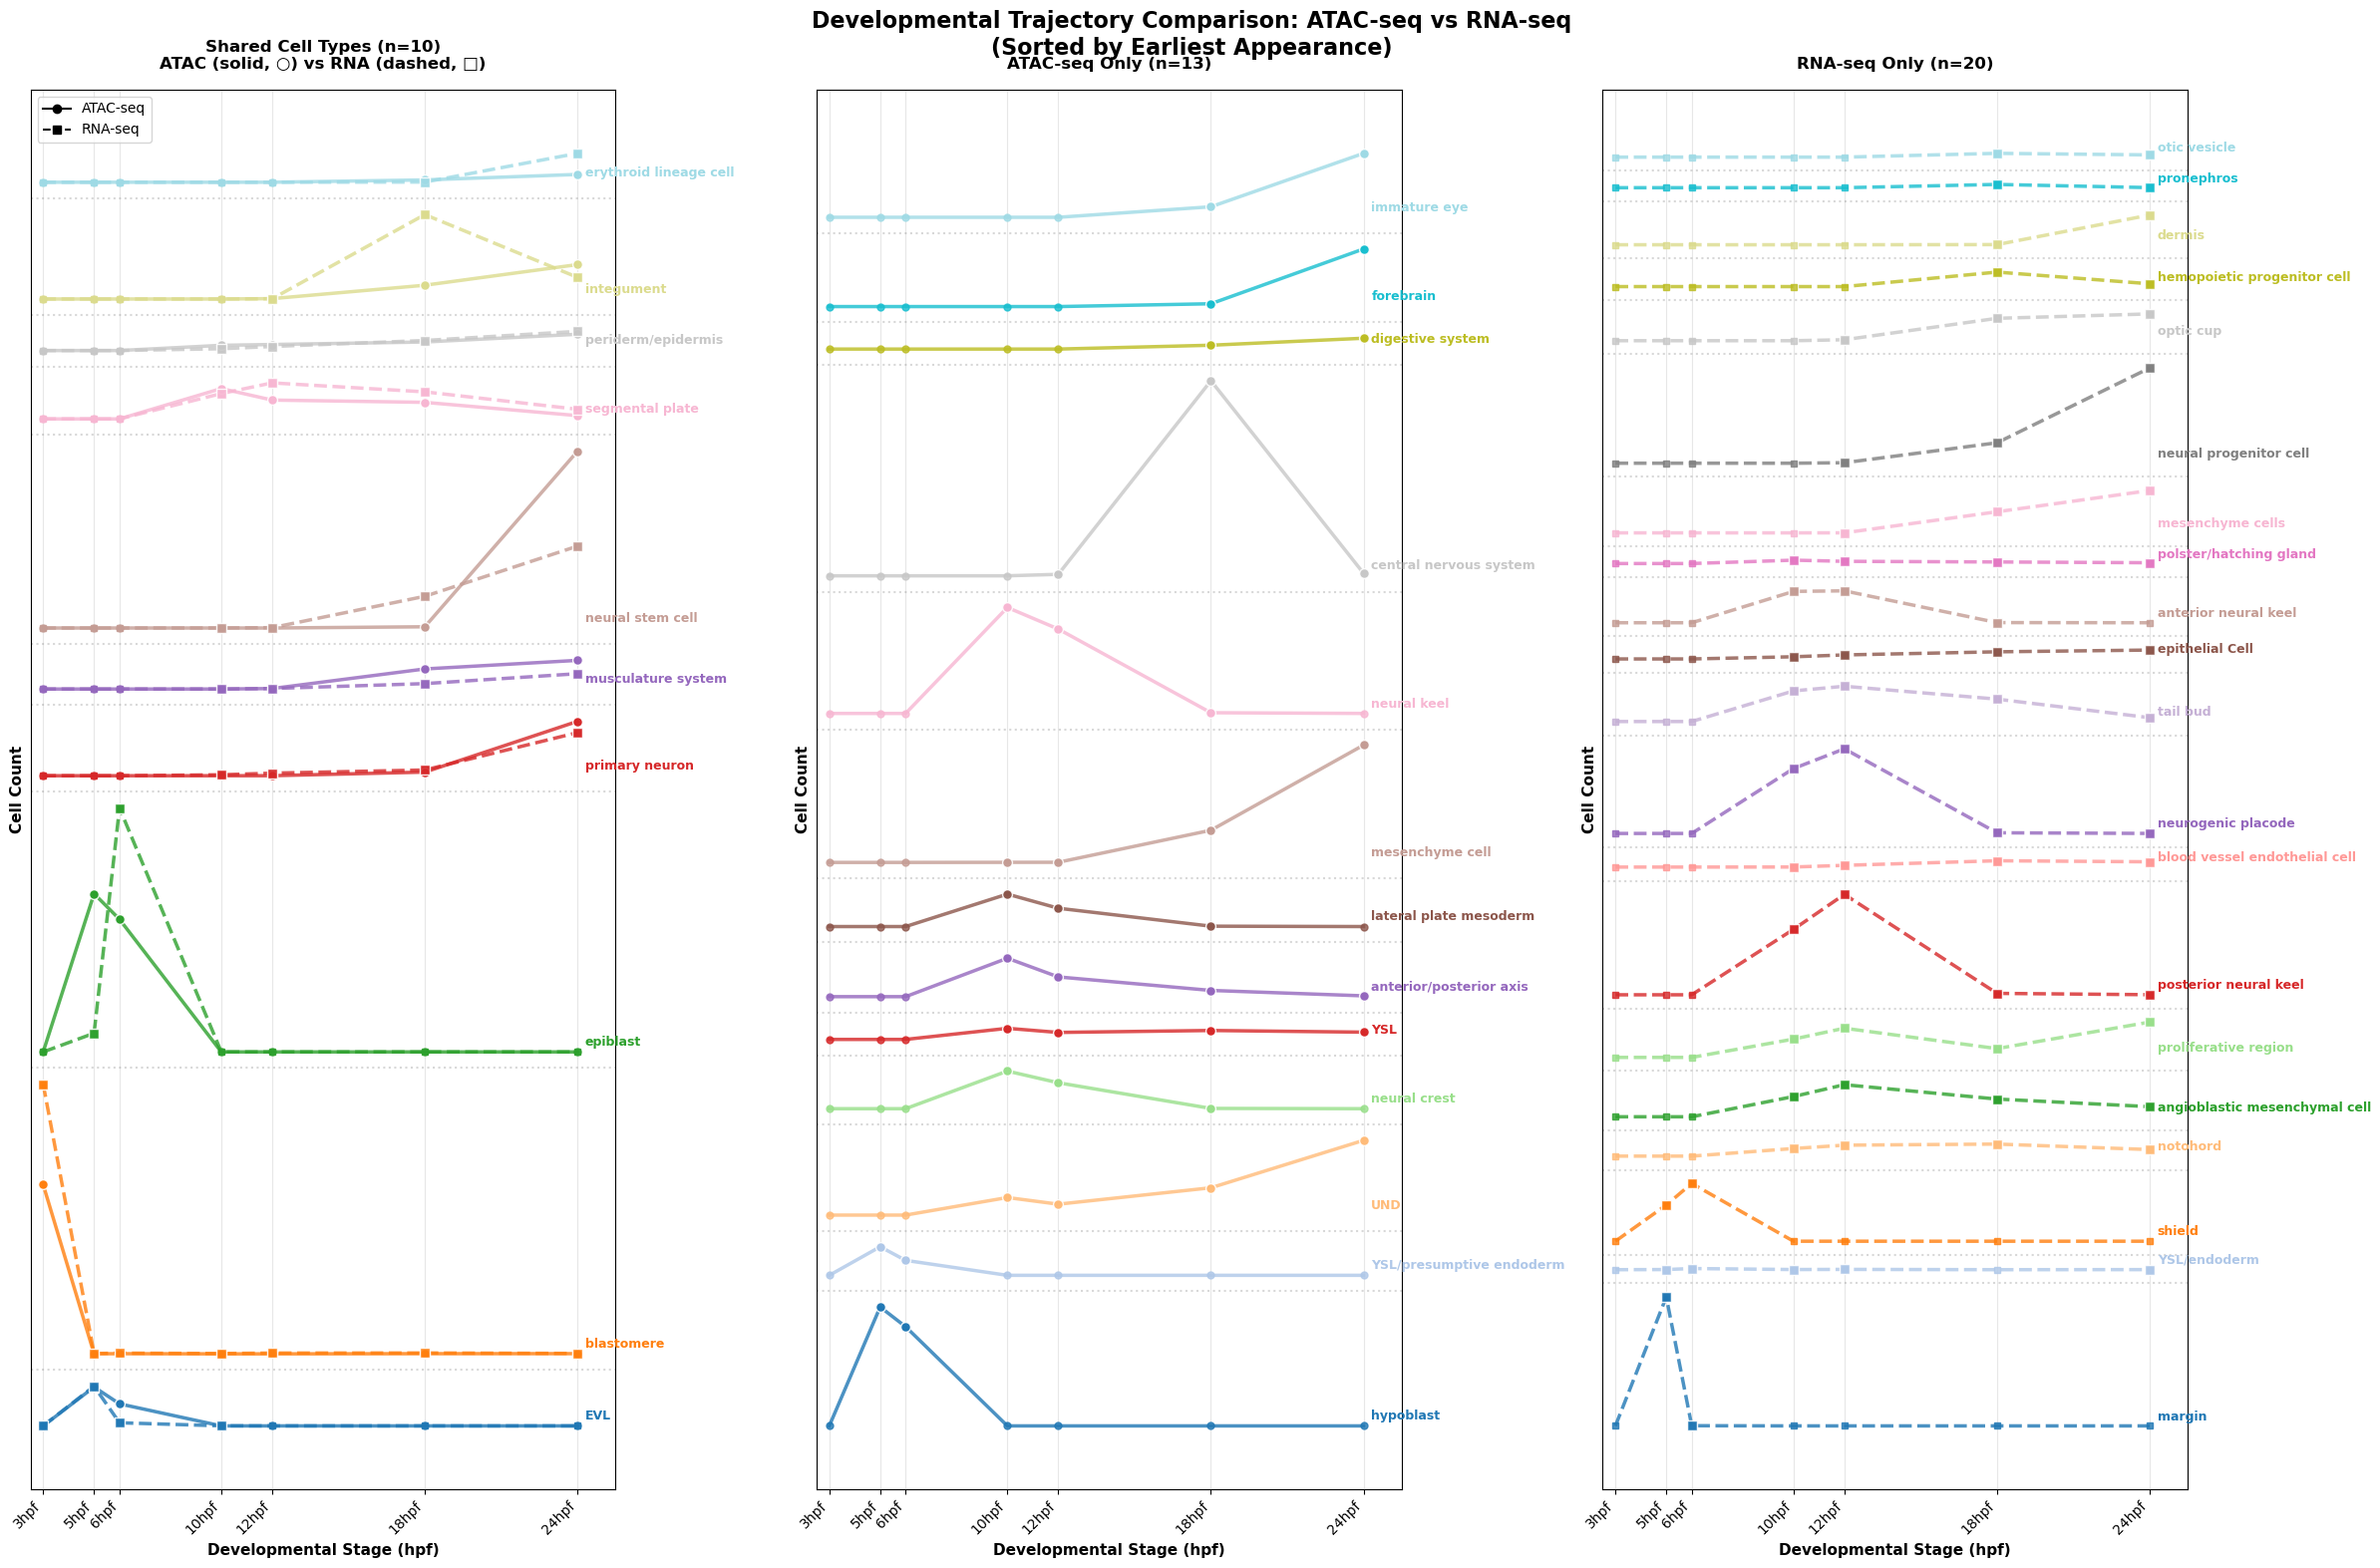

In [ ]:

atac_available = atac_metadata_df is not None and {'atac_cell_type', 'atac_stage'}.issubset(atac_metadata_df.columns)
atac_heatmap = process_trajectory_data(atac_metadata_df, 'atac_cell_type', 'atac_stage') if atac_available else None
rna_heatmap = process_trajectory_data(rna_metadata_df, 'celltype', 'stage')

common_cell_types = set(atac_heatmap.index) & set(rna_heatmap.index) if atac_available else set()
atac_only = set(atac_heatmap.index) - set(rna_heatmap.index) if atac_available else set()
rna_only = set(rna_heatmap.index) - set(atac_heatmap.index) if atac_available else set()
all_stages = sorted(set(atac_heatmap.columns if atac_available else []) | set(rna_heatmap.columns))

fig, axes = plt.subplots(1, 3, figsize=(24, 16))

plot_trajectories(axes[0], common_cell_types, atac_heatmap, rna_heatmap, all_stages, f'Shared Cell Types (n={len(common_cell_types)})\nATAC (solid, ○) vs RNA (dashed, □)', 'shared')
plot_trajectories(axes[1], atac_only, atac_heatmap, None, all_stages, f'ATAC-seq Only (n={len(atac_only)})', 'atac_only')
plot_trajectories(axes[2], rna_only, None, rna_heatmap, all_stages, f'RNA-seq Only (n={len(rna_only)})', 'rna_only')

fig.suptitle('Developmental Trajectory Comparison: ATAC-seq vs RNA-seq\n(Sorted by Earliest Appearance)',
             fontsize=16, fontweight='bold', y=0.98)

if common_cell_types and atac_available:
    legend_elements = [plt.Line2D([0], [0], color='black', linestyle='-', marker='o', label='ATAC-seq'), plt.Line2D([0], [0], color='black', linestyle='--', marker='s', label='RNA-seq')]
    axes[0].legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0, 1))

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.savefig('../../data/embryo/plotsatac_rna_developmental_trajectories_comparison.png', bbox_inches='tight')
plt.show()
